In [1]:
import multiprocessing
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

PATH = os.getcwd()


#file_name = '/tmp/lbnl/delete_me/half_full_40_1/run_train/run_train_1_lr=0.001_2020-06-15_02-47-57ak0kvjv5/best/policy_70'#'half_full__sim35_jun_1/full_train_1/run_train/run_train_1_lr=0.001_2020-06-02_04-24-28fbkv0xnf/best/policy'#'policy'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_1/run_train/run_train_0_lr=0.001_2020-06-16_19-51-18bvdh60uo/best/policy_140'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_0/run_train/run_train_1_lr=0.001_2020-06-16_17-51-00fejko8f_/best/policy_70'
#policy = os.path.join(PATH, file_name) 
start = 100
percentage_hack = 0.2

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
#tf.compat.v1.enable_eager_execution()
#policy = tf.saved_model.load(policy)
#infer = policy.signatures['serving_default']
done = False
obs = test_env.reset()
obs = obs.tolist()
while not done:
    #act_logits = infer(
    #    prev_reward=tf.constant([0.], tf.float32),
    #    observations=tf.constant([obs], tf.float32),
    #    is_training=tf.constant(False),
    #    seq_lens=tf.constant([0], tf.int32),
    #    prev_action=tf.constant([0], tf.int64)
    #)['behaviour_logits'].numpy()
    #act = np.argmax(act_logits)
    obs, r, done, _ = test_env.step(2)
    obs = obs.tolist()
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


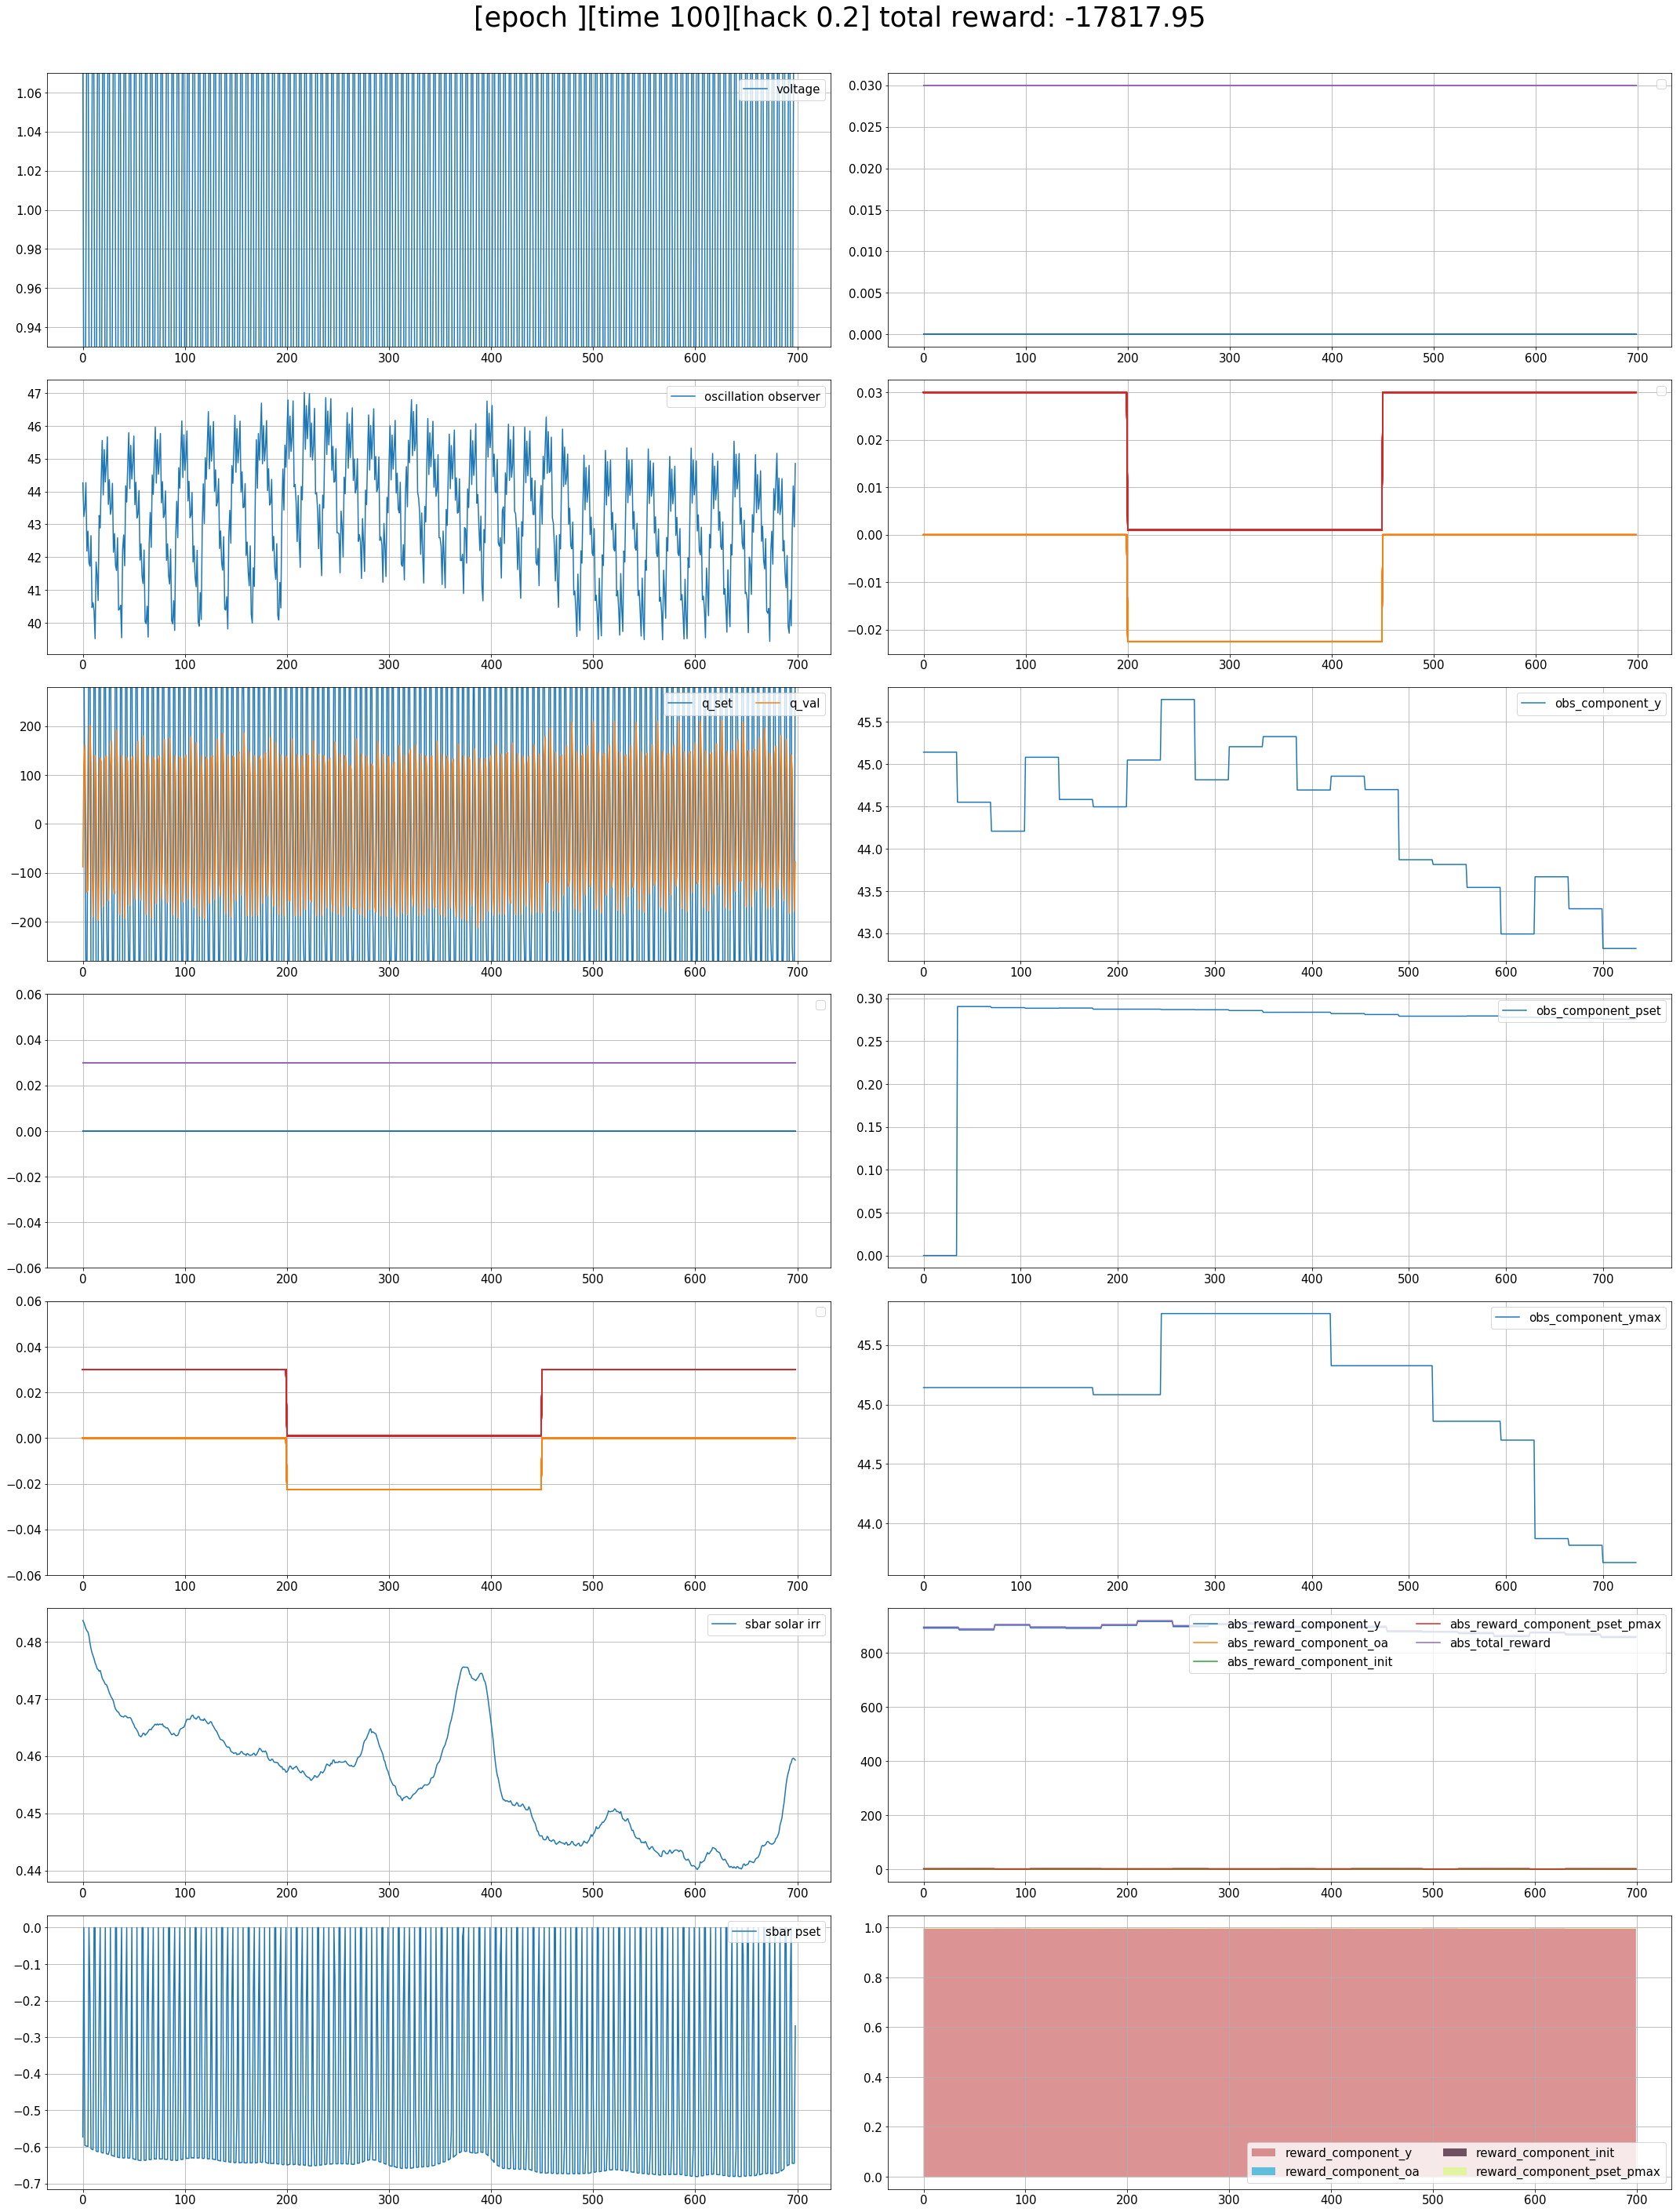

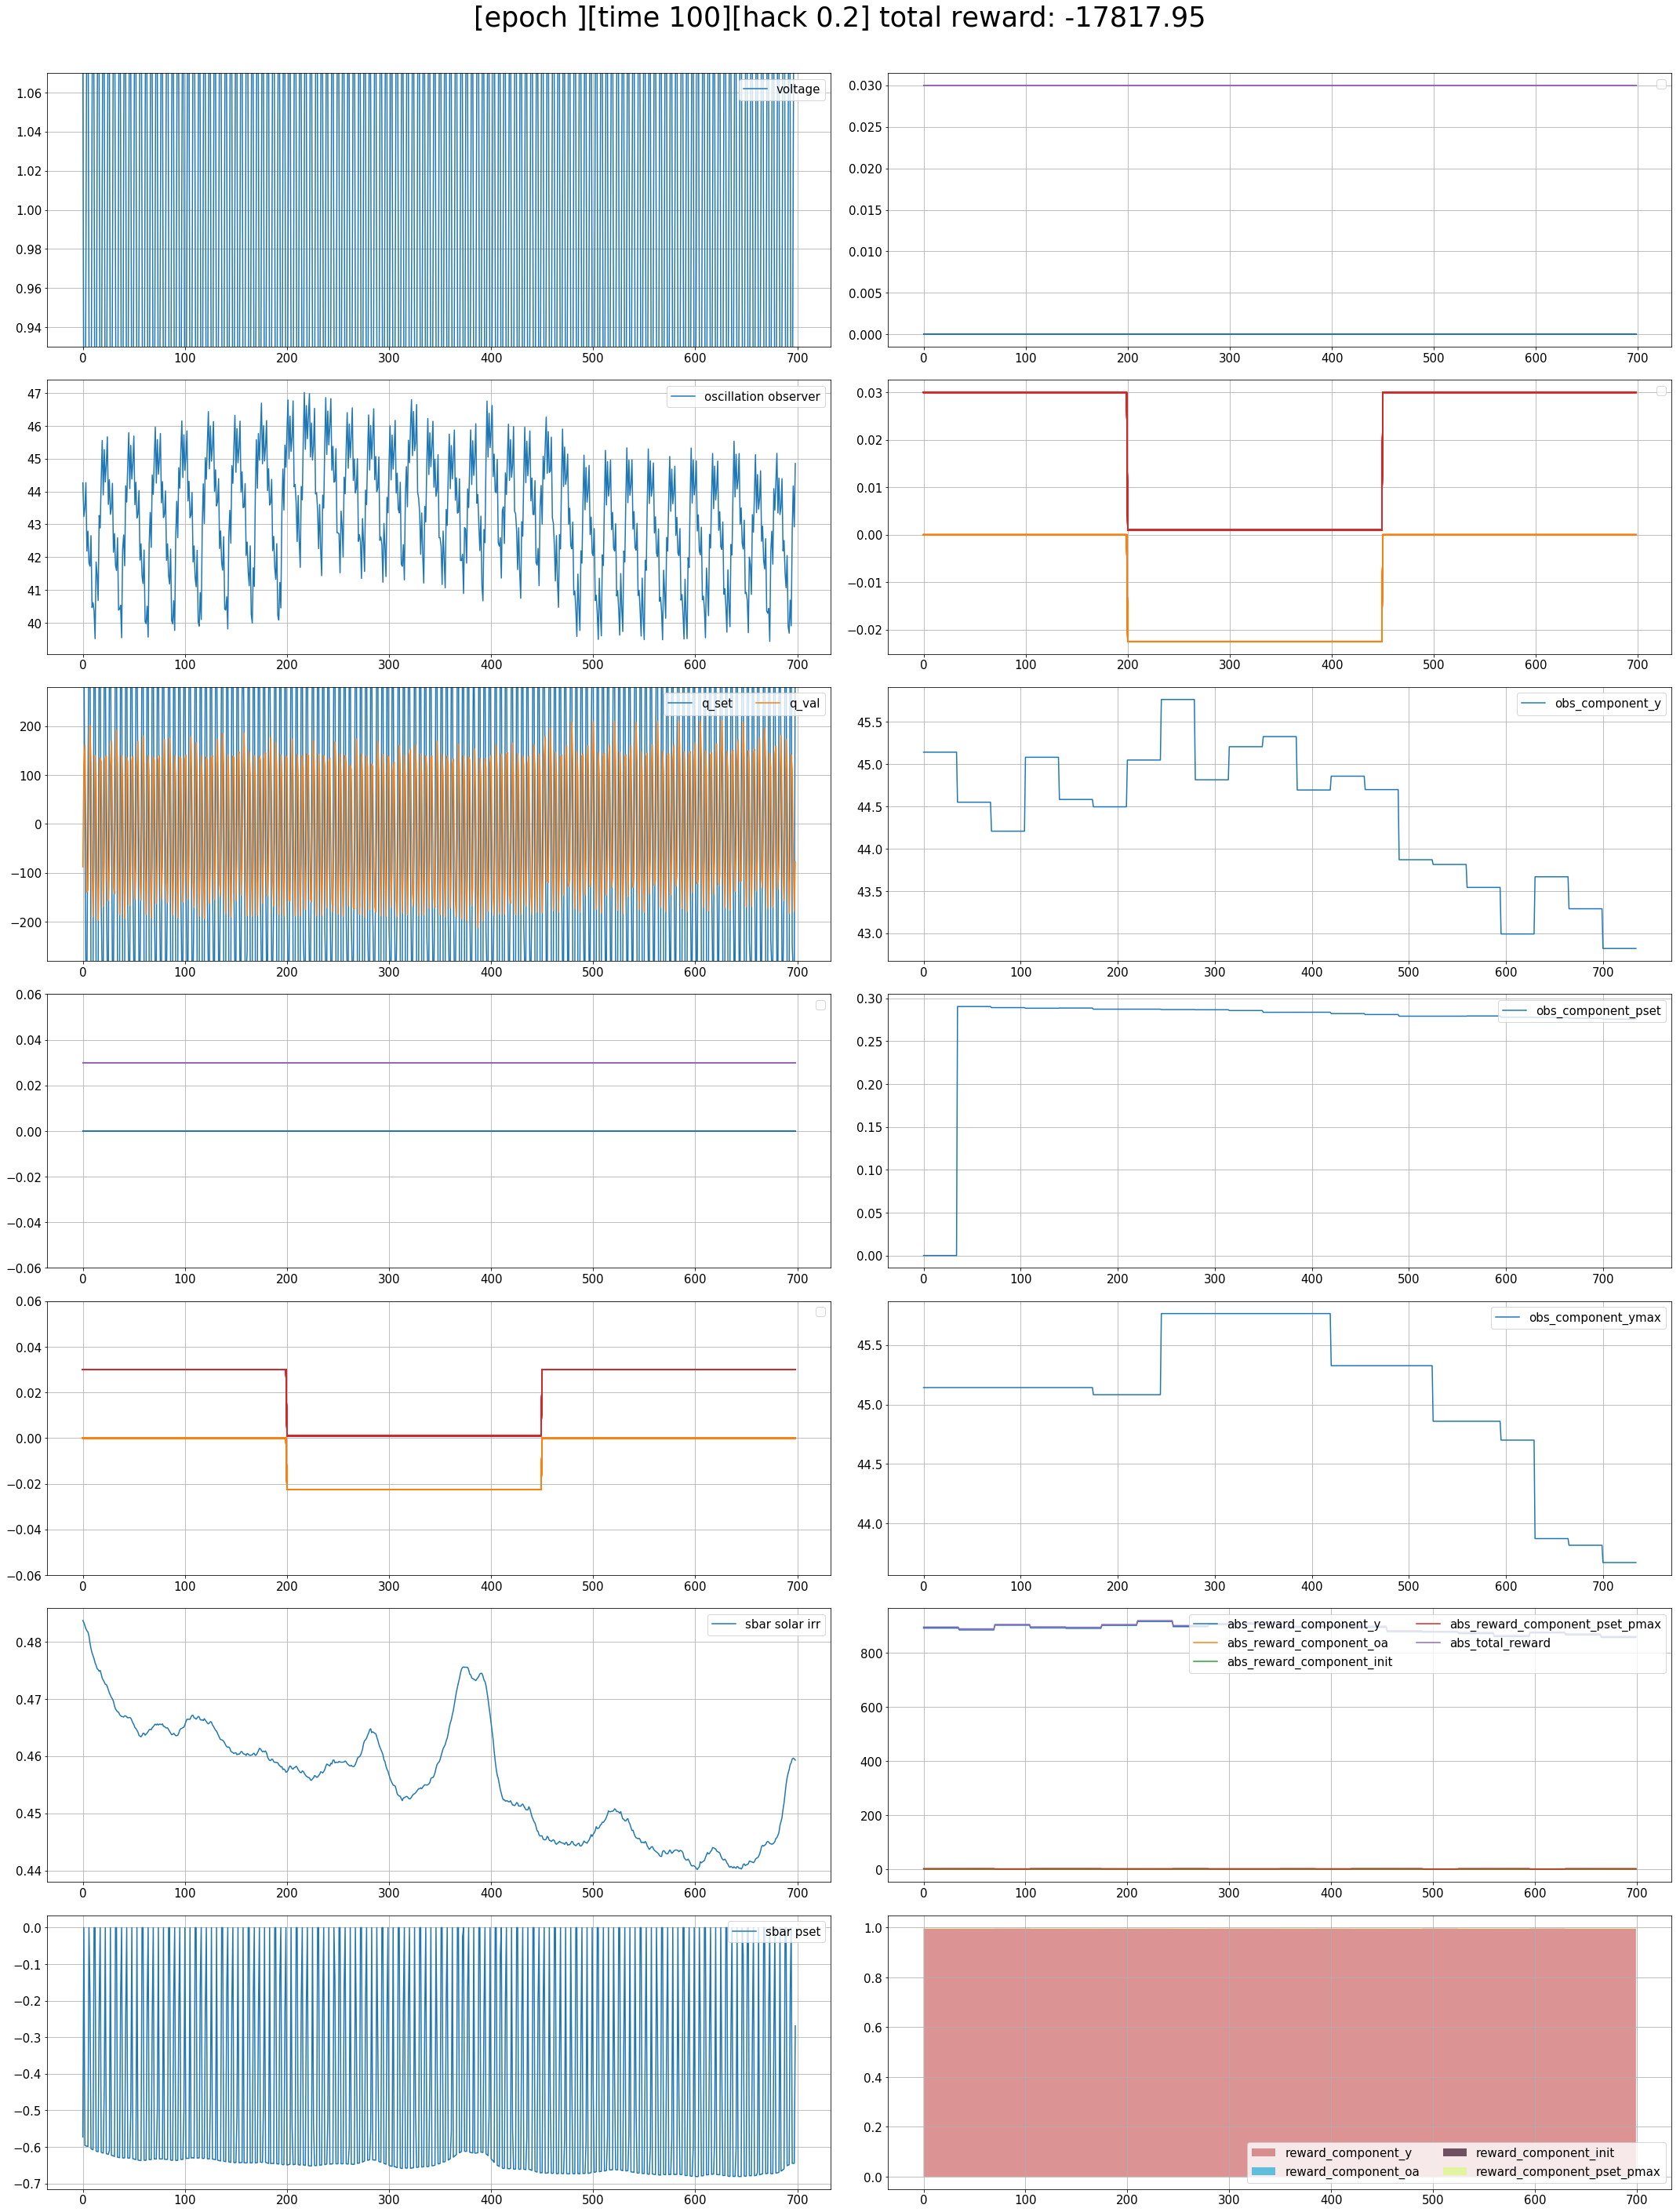

In [2]:
from pycigar.utils.output import plot_new
plot_new(log_dict, custom_metrics)

In [3]:
len(log_dict['inverter_s701a']['y'])

699

In [3]:
def get_translation_and_slope(a_val):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    og_point = points[0, 2]
    translation = points[:, 2] - og_point
    return translation, slope

In [4]:
result = {}
result['v'] = []
result['y'] = []
result['translation'] = []
result['slope'] = []
result['translation_adv'] = []
result['slope_adv'] = []
result['component_y'] = []
result['component_oa'] = []
result['component_init'] = []
result['component_pset_pmax'] = []
result['total_reward'] = []

node = 's701a'
translation, slope = get_translation_and_slope(log_dict['inverter_' + node]['control_setting'])
translation_adv, slope_adv = get_translation_and_slope(log_dict['adversary_inverter_' + node]['control_setting'])
component_y = np.array(log_dict['component_reward']['component_y'])
component_oa = np.array(log_dict['component_reward']['component_oa'])
component_init = np.array(log_dict['component_reward']['component_init'])
component_pset_pmax = np.array(log_dict['component_reward']['component_pset_pmax'])
total_reward = component_y + component_oa + component_init + component_pset_pmax

for i in range(len(log_dict[node]['voltage'])):
    result['v'].append(log_dict[node]['voltage'][i])
    result['y'].append(log_dict['inverter_' + node]['y'][i])
    result['translation'].append(translation[i])
    result['slope'].append(slope[i])
    result['translation_adv'].append(translation_adv[i])
    result['slope_adv'].append(slope_adv[i])

    result['component_y'].append(component_y[i])
    result['component_oa'].append(component_oa[i])
    result['component_init'].append(component_init[i])
    result['component_pset_pmax'].append(component_pset_pmax[i])
    result['total_reward'].append(total_reward[i])

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict(result)
#df.to_csv("eval_hist_{}_{}_new_new_filter.csv".format(start, percentage_hack))
df.to_csv("eval_hist_{}_{}_new_new_filter.csv".format('no', 'act'))

In [5]:
import pandas as pd
df = pd.read_csv('progress.csv')

In [11]:
result = {}
result['mean'] = []
result['std'] = []

for i in range(len(df)):
    result['mean'].append(df['episode_reward_mean'][i])
    result['std'].append(0)

df = pd.DataFrame.from_dict(result)
df.to_csv("reward_convergence.csv")

In [10]:
df['episode_reward_mean'][2]

-399.4700310652173

In [1]:
import os
directory = '/home/toanngo/Pictures/delete_me_frame_6/' #'/tmp/lbnl/' #os.path.join(PATH, 'half_full__sim35_jun_1')  #'/tmp/lbnl/full_eval_1616_lr2_20_256'
folders = [f for f in os.listdir(directory) if '.pickle' not in f]

In [2]:
def fileCount(path, extension):
    count = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.endswith(extension):
                count.append([root, dirs, f])
    return count

In [3]:
a = fileCount(directory, '.csv')

In [4]:
import pandas as pd
result = {}
for i, d in enumerate(a):
    ds = d[0] + '/' + d[2]
    df = pd.read_csv(ds)
    result[i] = df['episode_reward_mean']

In [5]:
df = pd.DataFrame.from_dict(result)

In [6]:
df

,0,1,2,3,4,5,6,7,8
0,-124.733187,-120.485120,-102.289615,-120.249109,-108.762985,-119.209334,-110.830612,-130.665923,-107.682624
1,-128.240234,-131.392893,-131.929315,-126.666641,-129.183459,-133.110645,-151.892438,-133.249988,-133.910929
2,-145.602201,-132.535419,-138.925326,-147.270567,-137.243807,-148.655824,-143.397555,-149.745163,-134.015769
3,-149.613860,-129.994851,-144.208541,-154.396356,-135.129883,-149.173709,-161.522344,-151.696059,-134.588681
4,-145.491646,-126.878234,-148.210240,-157.801259,-138.506289,-142.524477,-158.592731,-152.724875,-138.362299
...,...,...,...,...,...,...,...,...,...
145,-65.994040,-66.930591,-69.403591,-74.024675,-68.358770,-70.649498,-64.843002,-66.760699,-69.288631
146,-66.489066,-66.754796,-68.888942,-74.797142,-67.780246,-70.723710,-65.137597,-66.504298,-69.020151
147,-66.113612,-65.392108,-68.520443,-74.477506,-68.575381,-73.208149,-65.910093,-68.362421,-69.416979
148,-66.127386,-65.276016,-67.907658,-73.934017,-68.674282,-73.533728,-65.401543,-69.577083,-69.948487


In [28]:
import numpy as np
list(df[0:70].dropna(axis=1).mean(axis=1))
list(df[0:70].dropna(axis=1).std(axis=1))

[29.084070000865026,
 28.841222925678462,
 28.368101210780463,
 21.25157092379508,
 17.964176445187277,
 15.26870477986912,
 16.329870907457206,
 16.492524298614406,
 16.474167720859917,
 16.46543679091946,
 16.030430007454633,
 16.478830464543652,
 16.670218790320543,
 16.502391581856994,
 14.685953126661838,
 14.503589501133122,
 15.778393903823261,
 15.742872970803184,
 15.25643535400076,
 14.731582359278848,
 14.657241649601747,
 14.624996514856827,
 14.202689104505511,
 13.98750098306683,
 13.496154846700572,
 13.567965398705626,
 14.692640080619686,
 14.919477263341358,
 14.671656986415423,
 14.60116816565084,
 14.904167394697097,
 15.386142178850053,
 14.947898109995865,
 13.909947804441572,
 14.239360369434355,
 14.22357600712928,
 13.95479842135606,
 13.903461840550579,
 13.764375547368068,
 13.955285650703038,
 14.37494872649523,
 14.113804989673868,
 14.571573023265936,
 14.452423348299805,
 14.797238472088745,
 14.498040988465085,
 14.834409804946388,
 14.071224708921312,
 

In [7]:
result_all = {}
result_all['mean'] = []
result_all['std'] = []

result_all['mean'] = list(df.dropna(axis=1).mean(axis=1))
result_all['std'] = list(df.dropna(axis=1).std(axis=1))

df = pd.DataFrame.from_dict(result_all)
df.to_csv("reward_convergence_new_new_filter.csv")

In [1]:
import multiprocessing
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

PATH = os.getcwd()


file_name = 'policy'
policy = os.path.join(PATH, file_name) 
start = 11000
percentage_hack = 0.45

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
done = False
obs = test_env.reset()
obs = obs.tolist()
while not done:
    act = 2
    obs, r, done, _ = test_env.step(act)
    obs = obs.tolist()
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

In [4]:
nodes = ['s701a', 's701b', 's701c', 's712c', 's713c', 's714a', 's714b', 's718a', 's720c', 's722b', 's722c', 's724b', 's725b', 's727c', 's728', 's729a', 's730c', 's731b', 's732c', 's733a', 's734c', 's735c', 's736b', 's737a', 's738a', 's740c', 's741c', 's742a', 's742b', 's744a']
result = {}
for node in nodes:
    result[node] = log_dict[node]['voltage']



NameError: name 'pd' is not defined

In [6]:
import pandas as pd
df = pd.DataFrame.from_dict(result)

In [10]:

result = {}
result['mean'] = df.mean(axis=1)
result['std'] = df.std(axis=1)

In [11]:
df = pd.DataFrame.from_dict(result)
df.to_csv("voltage_analysis.csv")